### Analysis/Detections on additional pixels:
- Start date: 03/07/23
- End date  : 

Input: 
- Dynamic Spectra/Time-series generated from 30 minutes of 150x150 ED2A images

Data stored on Setonix:
- Location: /scratch/director2183/msok/data/eda2/2023_06_01_eda2_10min_ch294/processing/cpu_all/flipped_as_on_laptop/20230601_100213_100ms_ch294/fits_images/dynamic_spectra
- Time series are inside these specific files: **cd 0050_0050**
- Dynamic Spectra stored as: **0050_0050.fits**
- Time series are stored as: **0050_0050_series.fits**

**Pixel analysed here:** (90,90)

where X_Y.fits: X,Y coordinates in the image

#### Importing required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import time as ptime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
# import io_fits
import time
import sys
import pandas as pd
# Importing fits library for viewing the images 
from astropy.io import fits

# For visualisations and creating graphs
import seaborn as sns

# In order to plot the curves
from scipy.stats import norm

# In order to create animations from these histograms
import matplotlib.animation as animation

#### Reading time-series

In [2]:
DS_0090_0090_series_fits = fits.open('/data/gayatri/Part_C/Analysis/0090_0090/0090_0090_series.fits')
DS_0090_0090_series = DS_0090_0090_series_fits[0].data

In [3]:
DS_0090_0090_series.shape

(7, 599)

In [94]:
# Initialize an empty DataFrame to store all the values obtained from descriptive statistics
df_0090_0090 = pd.DataFrame(columns=['Mean', 'Median', 'Min','Max','SD'])

# Print the DataFrame
print(df_0090_0090)

row_number = 0
# Iterate through the numpy array: DS_0050_0050_series
for row in DS_0090_0090_series:
    
    # Compute descriptive statistics for that row(DM):
    row_number = row_number + 1; 
    
    mean_value = row.mean()
    median_value = np.median(row)
    min_value = row.min()
    max_value = row.max()
    std_deviation_value = np.std(row)
    
    # Add these values to the df
    # print("Computing + Adding descriptive statistics to df for Row:",row_number)
    # print()
    df_0090_0090.loc[row_number, 'Mean'] = mean_value
    df_0090_0090.loc[row_number, 'Median'] = median_value
    df_0090_0090.loc[row_number, 'Min'] = min_value
    df_0090_0090.loc[row_number, 'Max'] = max_value
    df_0090_0090.loc[row_number, 'SD'] = std_deviation_value    

Empty DataFrame
Columns: [Mean, Median, Min, Max, SD]
Index: []


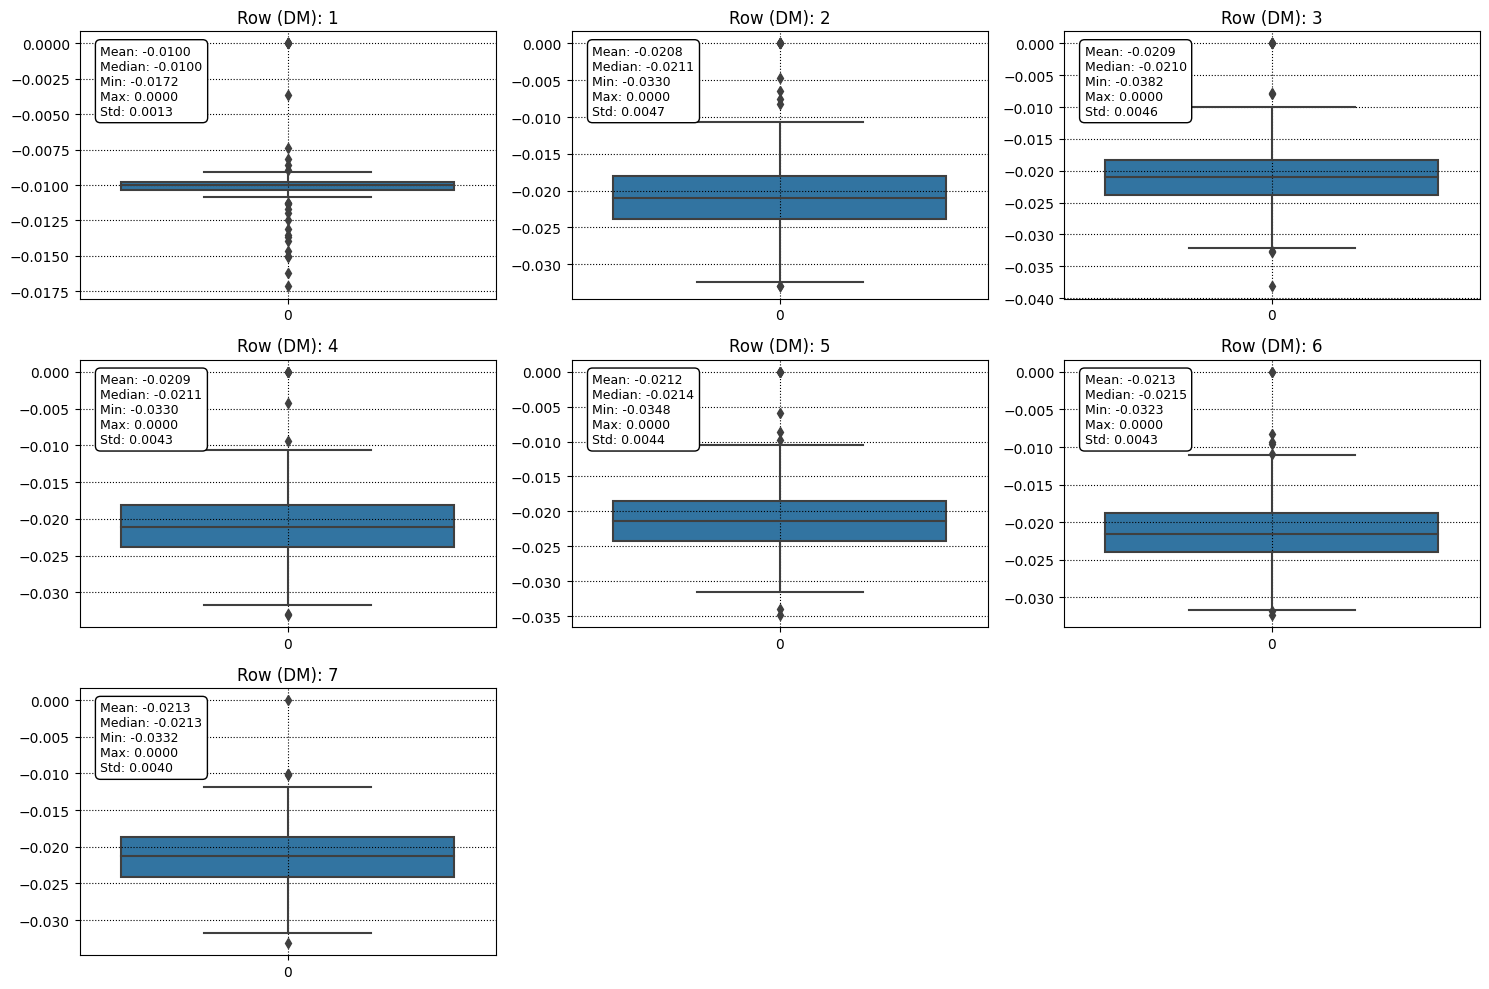

In [97]:
# Set the number of rows and columns for the subplot grid
rows = 3
cols = 3

# Create a figure and axis objects using matplotlib
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes object for easier iteration
axes = axes.flatten()

# Iterate over the axes and plot the boxplots
for i, ax in enumerate(axes):
    if i < len(DS_0090_0090_series):
        sns.boxplot(DS_0090_0090_series[i], ax=ax)
        ax.set_title(f'Row (DM): {i+1}')
        
        # Add a grid to the subplot
        ax.grid(True, color='black',linestyle=':')
        
        # Compute descriptive statistics
        mean = DS_0090_0090_series[i].mean()
        median = np.median(DS_0090_0090_series[i])
        minimum = DS_0090_0090_series[i].min()
        maximum = DS_0090_0090_series[i].max()
        std = np.std(DS_0090_0090_series[i])
        
        # Label descriptive statistics on the plot
        text = f"Mean: {mean:.4f}\nMedian: {median:.4f}\nMin: {minimum:.4f}\nMax: {maximum:.4f}\nStd: {std:.4f}"
        ax.text(0.05, 0.95, text, transform=ax.transAxes, verticalalignment='top', fontsize=9, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4'))
        
    else:
        fig.delaxes(ax)  # Remove any extra empty subplots

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# print("Printing descriptive statistics corresponding to every row (DM)")
# print(df_0090_0090)

#### How to search de-dispersed time series images for FRB-like (or dispersed in general) signals?

In [8]:
# Initialise an empty dataframe to save all the candidate
# Initialize an empty DataFrame to store all the values obtained from descriptive statistics
df_candidates_0090_0090 = pd.DataFrame(columns=['DM_index', 't_start', 'SNR'])

# Print the DataFrame
print(df_candidates_0090_0090)

Empty DataFrame
Columns: [DM_index, t_start, SNR]
Index: []


#### Threshold = Mean + 10Sigma

In [33]:
# Number of potential candidates
candidate_count = 0
candidate_row_count = 0

# Candidate list
candidate_list = []

# Number of potential candidates in that row 
candidates_row_list = []

# threshold_list 
threshold_list_10Sigma = []

row_number = 0
# Iterate through every row/DM of the numpy array: DS_0090_0090_series
for row in DS_0090_0090_series:
    
    # Number of candidates corresponding to that row 
    candidate_row_count = 0
    
    # Step 1: Computing the threshold 
    mean_value = row.mean()
    std_deviation_value = np.std(row)
    threshold = mean_value + (10*std_deviation_value)
    threshold_round = round(threshold,4)
    threshold_list_10Sigma.append(threshold_round)
    
    print("row(DM):",row_number,"threshold:",round(threshold,4))
    
    # Step 2: Compute median and rms 
    median = np.median(row)
    q1 = np.percentile(row, 25)
    q3 = np.percentile(row, 75)
    iqr = q3 - q1
    rms = iqr/1.35
    
    # Step 2a: Alternate method for rms calculation
    squared_values = np.square(row)
    mean_squared = np.mean(squared_values)
    rms_2 = np.sqrt(mean_squared)
    
    # Step 3: Iterate through all intensity values corresponding to that row/DM
    value_count = 0
    for value in row: 
        
        # Step 3A: Calculate SNR
        snr = (value - median)/rms
        
        # Step 3B: Calculate if SNR >= 10/7/5 
        if(snr >= 10):
    
            potential = [row_number, value_count, round(snr,2)]
            candidate_list.append(potential)
            
            candidate_count += 1
            candidate_row_count += 1
            # print("DM:",row_number,",time:", value_count, ",SNR:",round(snr,2))
            
        # Moving to the next value 
        value_count += 1
       
    # Adding number of candidates corresponding to that row 
    row_candidate_count = [row_number, candidate_row_count]
    candidates_row_list.append(row_candidate_count)
    
    # Moving to the next row 
    row_number = row_number + 1;

row(DM): 0 threshold: 0.0025
row(DM): 1 threshold: 0.0267
row(DM): 2 threshold: 0.0252
row(DM): 3 threshold: 0.0224
row(DM): 4 threshold: 0.0228
row(DM): 5 threshold: 0.0212
row(DM): 6 threshold: 0.0185


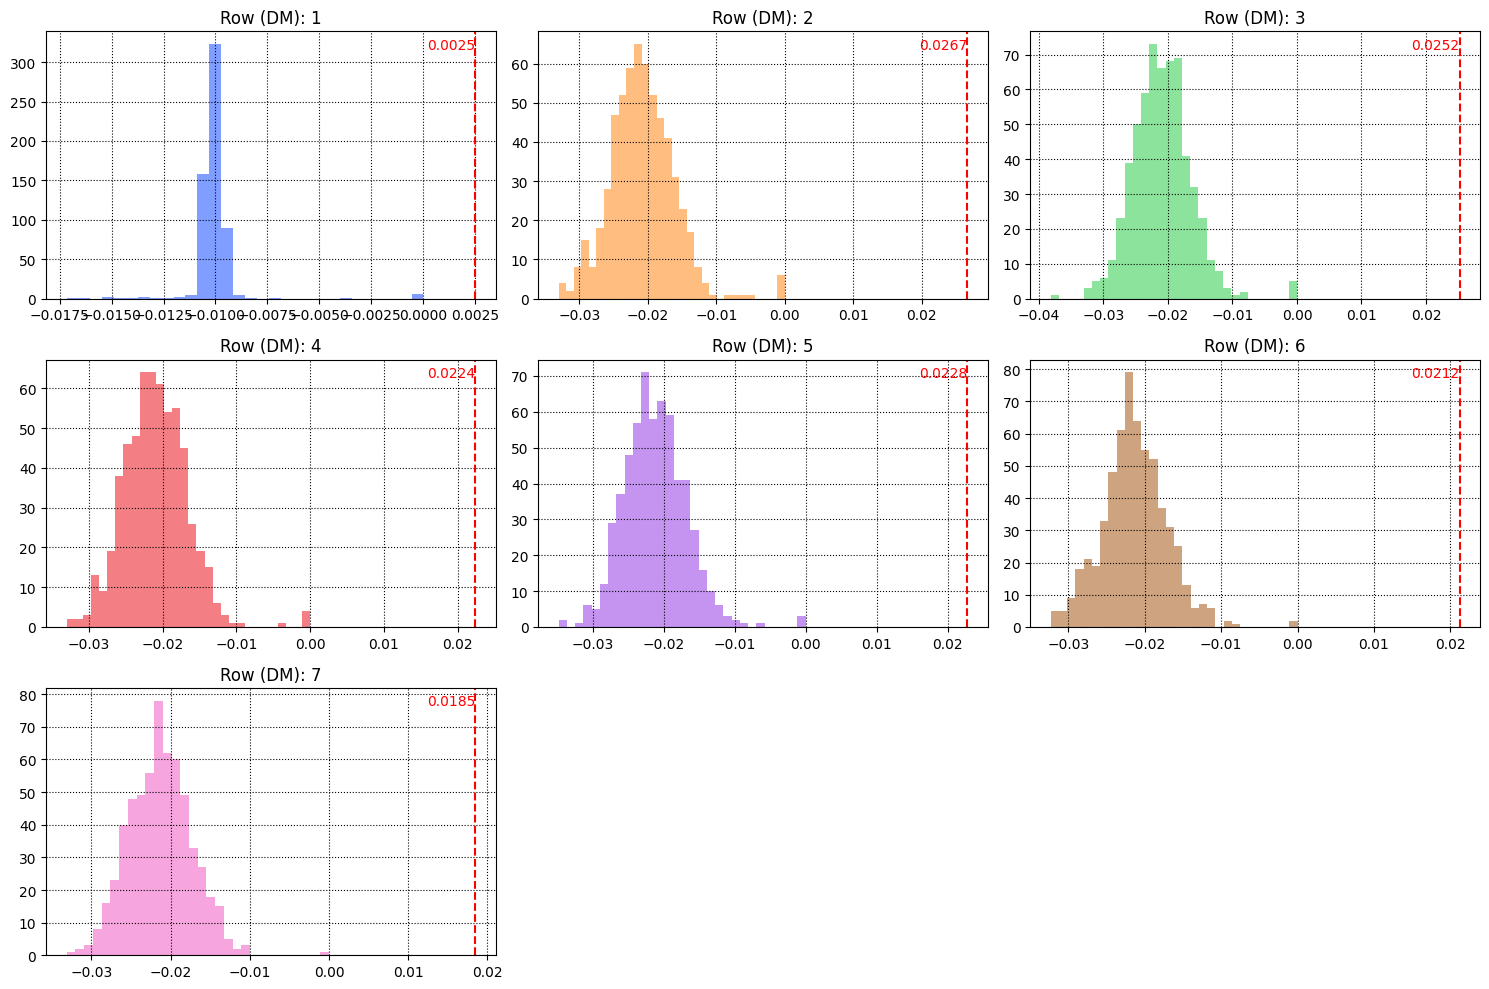

Number of candidates (SNR>10) : 19
[Row, Candidates per row]: [[0, 8], [1, 0], [2, 5], [3, 0], [4, 3], [5, 2], [6, 1]]


[[0, 0, 24.25],
 [0, 1, 24.25],
 [0, 2, 24.25],
 [0, 3, 24.25],
 [0, 4, 24.25],
 [0, 5, 24.25],
 [0, 597, 6.34],
 [0, 598, 15.47],
 [2, 0, 5.12],
 [2, 1, 5.12],
 [2, 2, 5.12],
 [2, 3, 5.12],
 [2, 4, 5.12],
 [4, 0, 5.14],
 [4, 1, 5.14],
 [4, 2, 5.14],
 [5, 0, 5.6],
 [5, 1, 5.6],
 [6, 0, 5.25]]

In [99]:
# Set the number of rows and columns for the subplot grid
rows = 3
cols = 3

# Create a figure and axis objects using matplotlib
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes object for easier iteration
axes = axes.flatten()

# Colours 
palette = 'bright'

count = 0 
# Iterate over the axes and plot the boxplots
for i, ax in enumerate(axes):
    if i < len(DS_0090_0090_series):
        # sns.boxplot(DS_0050_0050_series[i], ax=ax)
        ax.hist(DS_0090_0090_series[i], bins=30, color=sns.color_palette(palette)[i], alpha=0.5)
        ax.set_title(f'Row (DM): {i+1}')
        
        # Setting x-axis/y-axis scale to log
        # ax.set_yscale('log')
        
        # Marking the threshold
        # Plotting a vertical line at x=threshold
        threshold_line = threshold_list_10Sigma[count]
        count += 1
        ax.axvline(x=threshold_line, color='red', linestyle='--')
        
        # Labelling the red line
        # ax.text(threshold_line, ax.get_ylim()[1]*0.95, 'Threshold', color='red', ha='right')
        ax.text(threshold_line, ax.get_ylim()[1]*0.95, threshold_line, color='red', ha='right',va='center')
        
        # Add a grid to the subplot
        ax.grid(True, color='black',linestyle=':')
        
    else:
        fig.delaxes(ax)  # Remove any extra empty subplots

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Printing number of possible candidates
print("Number of candidates (SNR>10) :", candidate_count)
print("[Row, Candidates per row]:",candidates_row_list)
# print("Candidate list: [DM_index, Arrival_times, SNR] \n")
candidate_list

#### Threshold = Mean + 7Sigma

In [55]:
# Number of potential candidates
candidate_count = 0
candidate_row_count = 0

# Candidate list
candidate_list = []

# Number of potential candidates in that row 
candidates_row_list = []

# threshold_list 
threshold_list_7Sigma = []

row_number = 0
# Iterate through every row/DM of the numpy array: DS_0090_0090_series
for row in DS_0090_0090_series:
    
    # Number of candidates corresponding to that row 
    candidate_row_count = 0
    
    # Step 1: Computing the threshold 
    mean_value = row.mean()
    std_deviation_value = np.std(row)
    threshold = mean_value + (7*std_deviation_value)
    threshold_round = round(threshold,4)
    threshold_list_7Sigma.append(threshold_round)
    
    print("row(DM):",row_number,"threshold:",round(threshold,4))
    
    # Step 2: Compute median and rms 
    median = np.median(row)
    q1 = np.percentile(row, 25)
    q3 = np.percentile(row, 75)
    iqr = q3 - q1
    rms = iqr/1.35
    
    # Step 2a: Alternate method for rms calculation
    squared_values = np.square(row)
    mean_squared = np.mean(squared_values)
    rms_2 = np.sqrt(mean_squared)
    
    # Step 3: Iterate through all intensity values corresponding to that row/DM
    value_count = 0
    for value in row: 
        
        # Step 3A: Calculate SNR
        snr = (value - median)/rms
        
        # Step 3B: Calculate if SNR >= threshold 
        if(snr >= 7):
    
            potential = [row_number, value_count, round(snr,2)]
            candidate_list.append(potential)
            
            candidate_count += 1
            candidate_row_count += 1
            # print("DM:",row_number,",time:", value_count, ",SNR:",round(snr,2))
            
        # Moving to the next value 
        value_count += 1
       
    # Adding number of candidates corresponding to that row 
    row_candidate_count = [row_number, candidate_row_count]
    candidates_row_list.append(row_candidate_count)
    
    # Moving to the next row 
    row_number = row_number + 1;

row(DM): 0 threshold: -0.0012
row(DM): 1 threshold: 0.0124
row(DM): 2 threshold: 0.0114
row(DM): 3 threshold: 0.0094
row(DM): 4 threshold: 0.0096
row(DM): 5 threshold: 0.0085
row(DM): 6 threshold: 0.0065


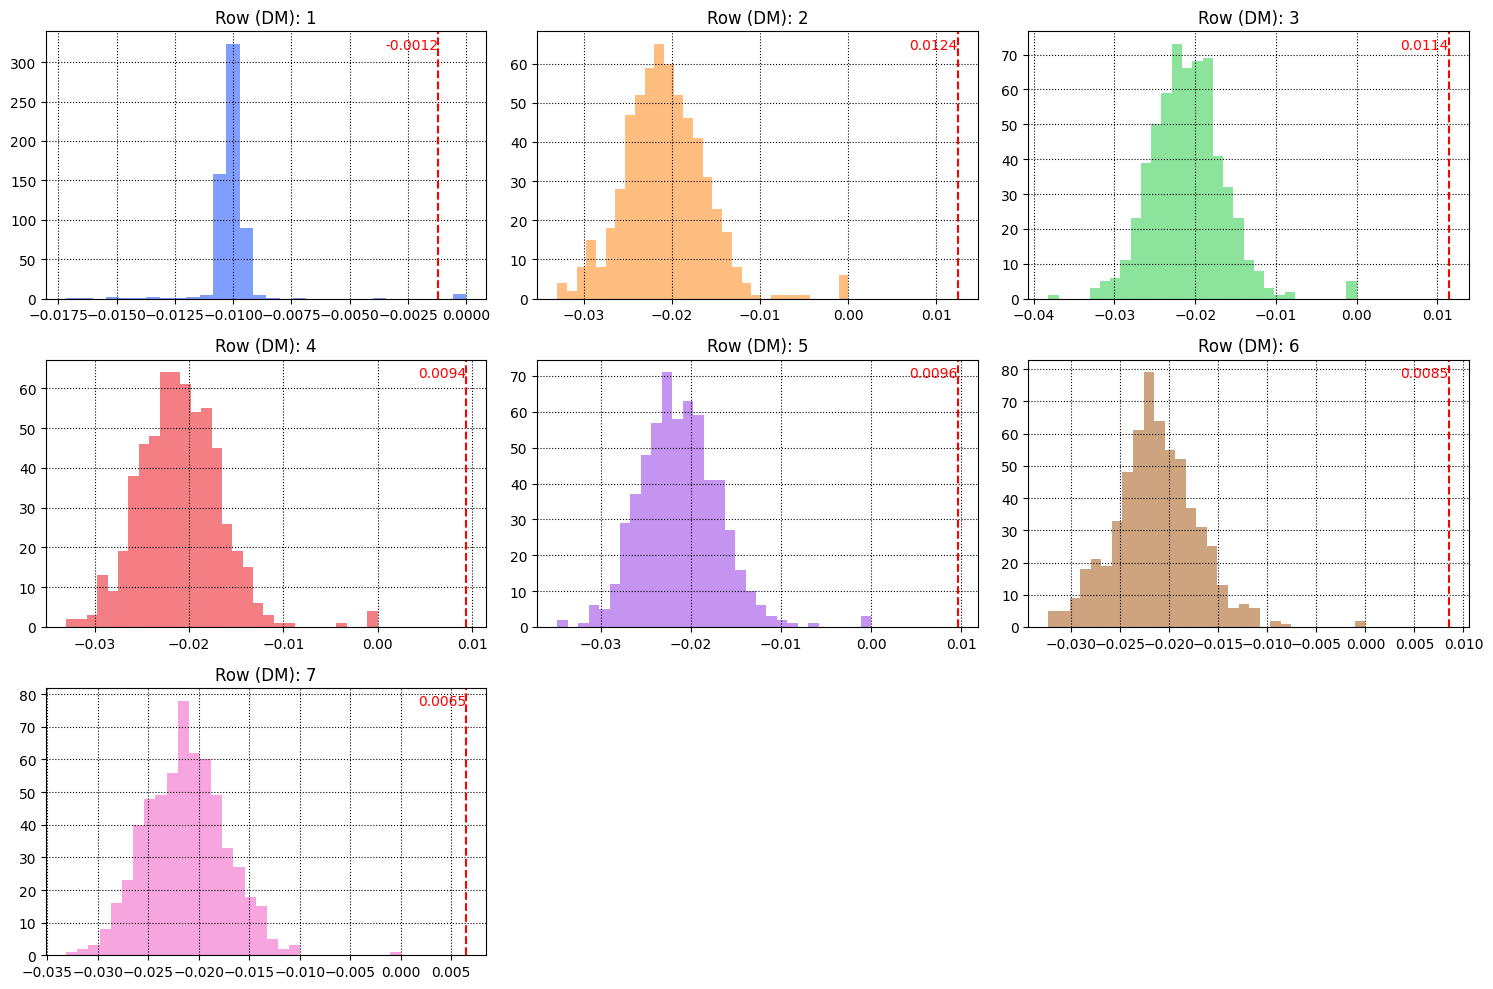

Number of candidates (SNR>10) : 19
[Row, Candidates per row]: [[0, 8], [1, 0], [2, 5], [3, 0], [4, 3], [5, 2], [6, 1]]


[[0, 0, 24.25],
 [0, 1, 24.25],
 [0, 2, 24.25],
 [0, 3, 24.25],
 [0, 4, 24.25],
 [0, 5, 24.25],
 [0, 597, 6.34],
 [0, 598, 15.47],
 [2, 0, 5.12],
 [2, 1, 5.12],
 [2, 2, 5.12],
 [2, 3, 5.12],
 [2, 4, 5.12],
 [4, 0, 5.14],
 [4, 1, 5.14],
 [4, 2, 5.14],
 [5, 0, 5.6],
 [5, 1, 5.6],
 [6, 0, 5.25]]

In [98]:
# Set the number of rows and columns for the subplot grid
rows = 3
cols = 3

# Create a figure and axis objects using matplotlib
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes object for easier iteration
axes = axes.flatten()

# Colours 
palette = 'bright'

count = 0 
# Iterate over the axes and plot the boxplots
for i, ax in enumerate(axes):
    if i < len(DS_0090_0090_series):
        # sns.boxplot(DS_0050_0050_series[i], ax=ax)
        ax.hist(DS_0090_0090_series[i], bins=30, color=sns.color_palette(palette)[i], alpha=0.5)
        ax.set_title(f'Row (DM): {i+1}')
        
        # Setting x-axis/y-axis scale to log
        # ax.set_yscale('log')
        
        # Marking the threshold
        # Plotting a vertical line at x=threshold
        threshold_line = threshold_list_7Sigma[count]
        count += 1
        ax.axvline(x=threshold_line, color='red', linestyle='--')
        
        # Labelling the red line
        # ax.text(threshold_line, ax.get_ylim()[1]*0.95, 'Threshold', color='red', ha='right')
        ax.text(threshold_line, ax.get_ylim()[1]*0.95, threshold_line, color='red', ha='right',va='center')
        
        # Add a grid to the subplot
        ax.grid(True, color='black',linestyle=':')
        
    else:
        fig.delaxes(ax)  # Remove any extra empty subplots

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Printing number of possible candidates
print("Number of candidates (SNR>10) :", candidate_count)
print("[Row, Candidates per row]:",candidates_row_list)
# print("Candidate list: [DM_index, Arrival_times, SNR] \n")
candidate_list

#### Threshold: Mean + 5Sigma

In [57]:
# Number of potential candidates
candidate_count = 0
candidate_row_count = 0

# Candidate list
candidate_list = []

# Number of potential candidates in that row 
candidates_row_list = []

# threshold_list 
threshold_list_5Sigma = []

row_number = 0
# Iterate through every row/DM of the numpy array: DS_0090_0090_series
for row in DS_0090_0090_series:
    
    # Number of candidates corresponding to that row 
    candidate_row_count = 0
    
    # Step 1: Computing the threshold 
    mean_value = row.mean()
    std_deviation_value = np.std(row)
    threshold = mean_value + (5*std_deviation_value)
    threshold_round = round(threshold,4)
    threshold_list_5Sigma.append(threshold_round)
    
    print("row(DM):",row_number,"threshold:",round(threshold,4))
    
    # Step 2: Compute median and rms 
    median = np.median(row)
    q1 = np.percentile(row, 25)
    q3 = np.percentile(row, 75)
    iqr = q3 - q1
    rms = iqr/1.35
    
    # Step 2a: Alternate method for rms calculation
    squared_values = np.square(row)
    mean_squared = np.mean(squared_values)
    rms_2 = np.sqrt(mean_squared)
    
    # Step 3: Iterate through all intensity values corresponding to that row/DM
    value_count = 0
    for value in row: 
        
        # Step 3A: Calculate SNR
        snr = (value - median)/rms
        
        # Step 3B: Calculate if SNR >= threshold 
        if(snr >= 5):
    
            potential = [row_number, value_count, round(snr,2)]
            candidate_list.append(potential)
            
            candidate_count += 1
            candidate_row_count += 1
            # print("DM:",row_number,",time:", value_count, ",SNR:",round(snr,2))
            
        # Moving to the next value 
        value_count += 1
       
    # Adding number of candidates corresponding to that row 
    row_candidate_count = [row_number, candidate_row_count]
    candidates_row_list.append(row_candidate_count)
    
    # Moving to the next row 
    row_number = row_number + 1;

row(DM): 0 threshold: -0.0037
row(DM): 1 threshold: 0.0029
row(DM): 2 threshold: 0.0022
row(DM): 3 threshold: 0.0007
row(DM): 4 threshold: 0.0008
row(DM): 5 threshold: -0.0
row(DM): 6 threshold: -0.0014


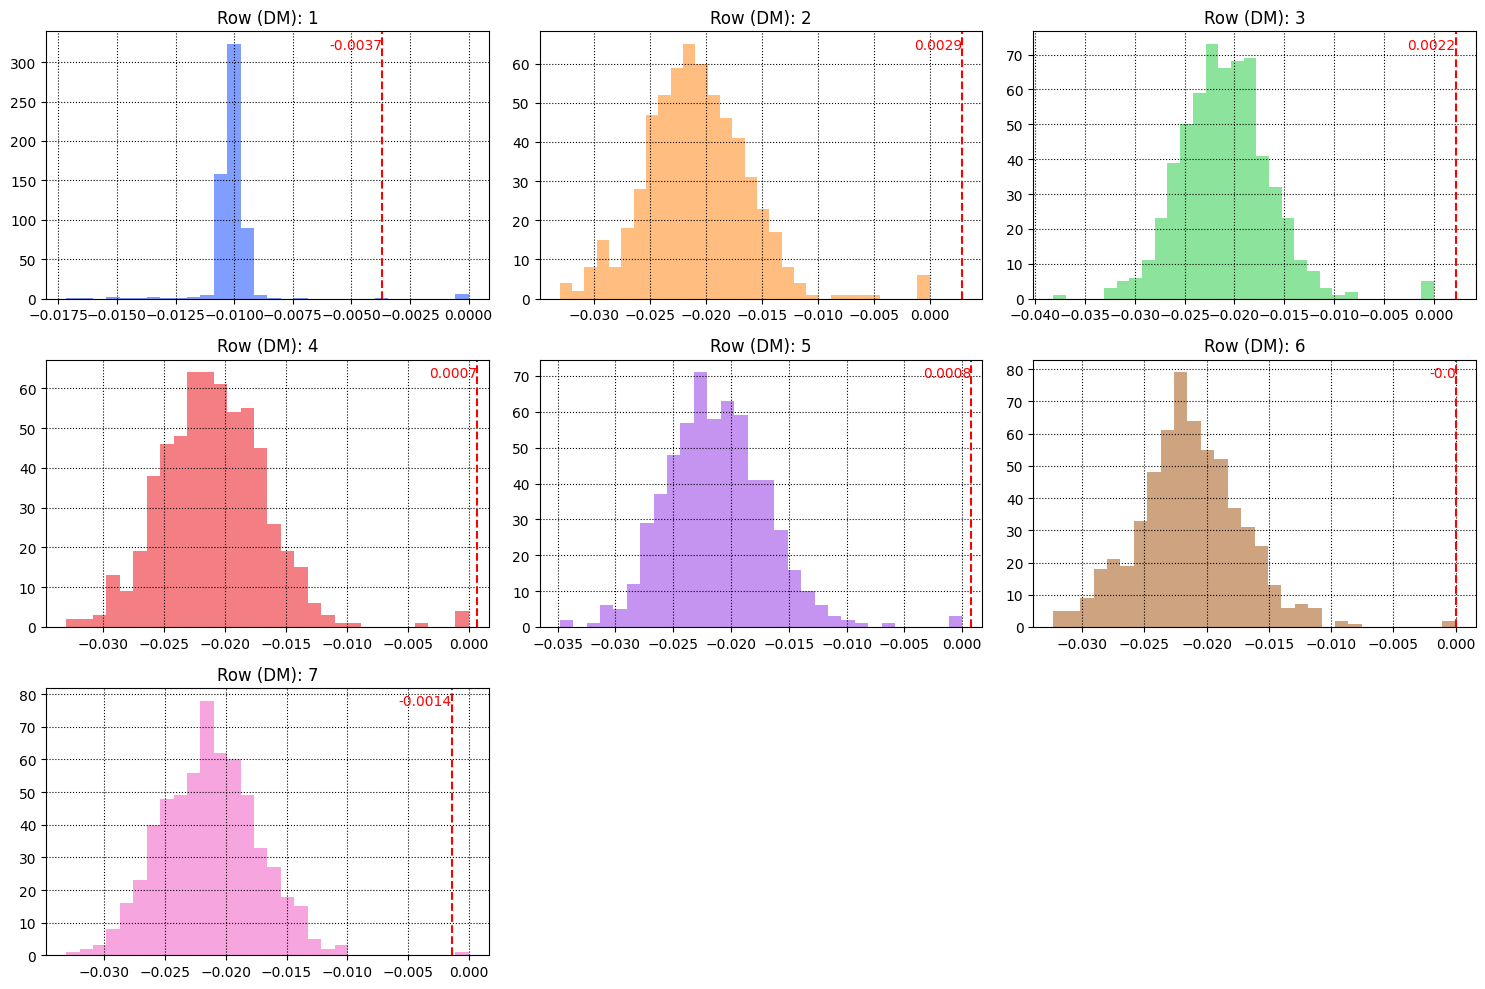

Number of candidates (SNR>10) : 19
[Row, Candidates per row]: [[0, 8], [1, 0], [2, 5], [3, 0], [4, 3], [5, 2], [6, 1]]


[[0, 0, 24.25],
 [0, 1, 24.25],
 [0, 2, 24.25],
 [0, 3, 24.25],
 [0, 4, 24.25],
 [0, 5, 24.25],
 [0, 597, 6.34],
 [0, 598, 15.47],
 [2, 0, 5.12],
 [2, 1, 5.12],
 [2, 2, 5.12],
 [2, 3, 5.12],
 [2, 4, 5.12],
 [4, 0, 5.14],
 [4, 1, 5.14],
 [4, 2, 5.14],
 [5, 0, 5.6],
 [5, 1, 5.6],
 [6, 0, 5.25]]

In [73]:
# Set the number of rows and columns for the subplot grid
rows = 3
cols = 3

# Create a figure and axis objects using matplotlib
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes object for easier iteration
axes = axes.flatten()

# Colours 
palette = 'bright'

count = 0 
# Iterate over the axes and plot the boxplots
for i, ax in enumerate(axes):
    if i < len(DS_0090_0090_series):
        # sns.boxplot(DS_0050_0050_series[i], ax=ax)
        ax.hist(DS_0090_0090_series[i], bins=30, color=sns.color_palette(palette)[i], alpha=0.5)
        ax.set_title(f'Row (DM): {i+1}')
        
        # Setting x-axis/y-axis scale to log
        # ax.set_yscale('log')
        
        # Marking the threshold
        # Plotting a vertical line at x=threshold
        threshold_line = threshold_list_5Sigma[count]
        count += 1
        ax.axvline(x=threshold_line, color='red', linestyle='--')
        
        # Labelling the red line
        # ax.text(threshold_line, ax.get_ylim()[1]*0.95, 'Threshold', color='red', ha='right')
        ax.text(threshold_line, ax.get_ylim()[1]*0.95, threshold_line, color='red', ha='right',va='center')
        
        # Add a grid to the subplot
        ax.grid(True, color='black',linestyle=':')
        
    else:
        fig.delaxes(ax)  # Remove any extra empty subplots
           
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Printing number of possible candidates
print("Number of candidates (SNR>10) :", candidate_count)
print("[Row, Candidates per row]:",candidates_row_list)
# print("Candidate list: [DM_index, Arrival_times, SNR] \n")
candidate_list

#### Savings results to an excel file:

In [15]:
# df = pd.DataFrame(candidate_list, columns=['DM', 'Arrival times', 'SNR'])
# df.to_excel('potential_candidates_0090_0090_10Sigma.xlsx', index=False)